In [3]:
import sys 
sys.path.append('..')

from models import DIFDensityEstimator,SoftmaxWeight,LocationScaleFlow
from models_em import EMDensityEstimator
from targets import Target, Uniform
%load_ext autoreload
%autoreload 2
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
from utils.color_visual import *

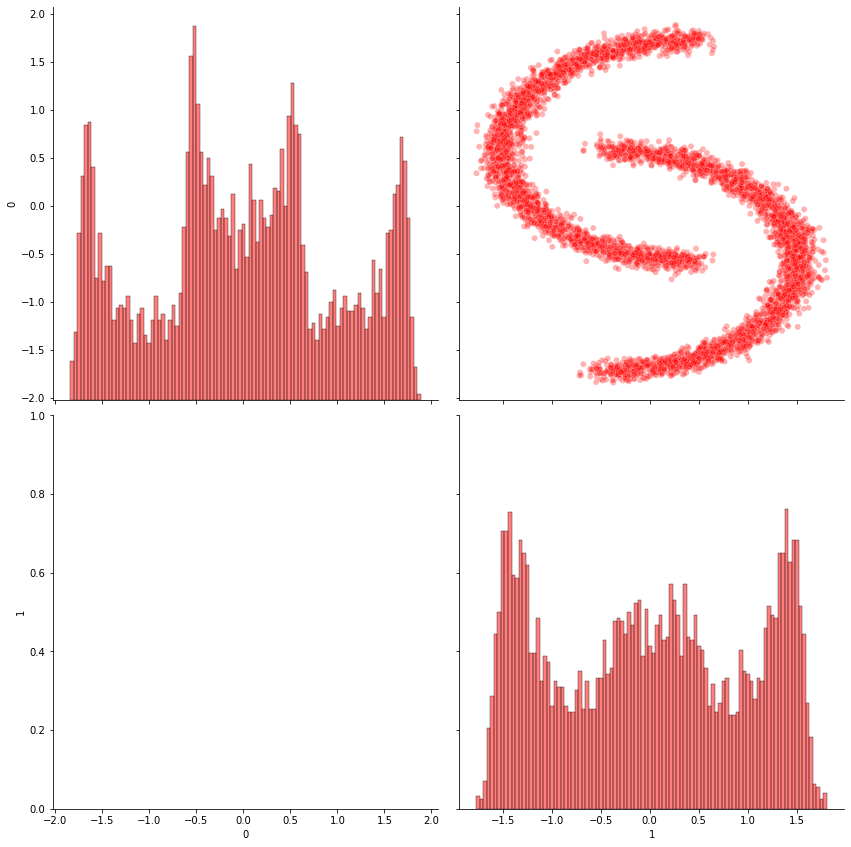

In [4]:
example = "Moons"
num_samples = 50000
target = Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

In [5]:
num_samples = target_samples.shape[0]
epochs = 50
K = 10
EM = EMDensityEstimator(target_samples,K)
loss_values = EM.train(epochs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.47it/s, loss = 1.6072484254837036]


c:\users\elouan\pycharmprojects\discretely-indexed-flows\venv\lib\site-packages\torch\functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


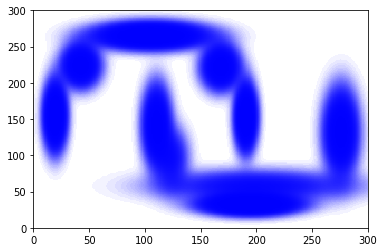

In [6]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(torch.min(target_samples[:,0]),torch.max(target_samples[:,0]),delta),torch.linspace(torch.min(target_samples[:,1]),torch.max(target_samples[:,1]),delta))
density = torch.exp(EM.log_density(grid)).reshape(delta,delta)
plt.pcolormesh(torch.flip(torch.flip(density.T,[0,1]),[0,1]), cmap = blue_cmap)

In [7]:
#Run DIF
from torch import nn
initial_T = LocationScaleFlow(K,2)
initial_T.m = nn.Parameter(EM.m)
initial_T.log_s = nn.Parameter(EM.log_s)

initial_w = SoftmaxWeight(K, 2, [128,128,128])
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K,initial_w.network_dimensions[-2]))

dif = DIFDensityEstimator(target_samples,K)
dif.T = initial_T
dif.w = initial_w

epochs = 100
dif.train(epochs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s, loss = 1.160126]


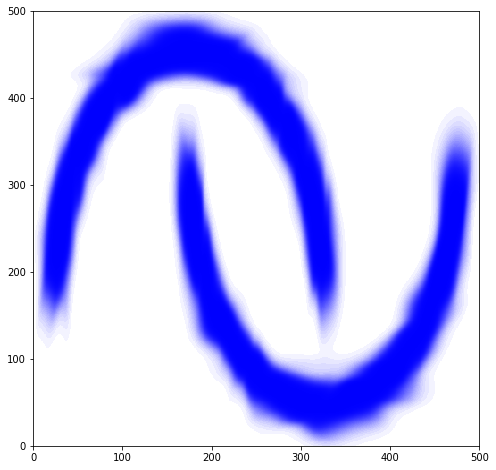

In [8]:
delta = 500
grid = torch.cartesian_prod(torch.linspace(torch.min(target_samples[:,0]),torch.max(target_samples[:,0]),delta),torch.linspace(torch.min(target_samples[:,1]),torch.max(target_samples[:,1]),delta))
density = torch.exp(dif.log_density(grid)).reshape(delta,delta)
plt.figure(figsize = (8,8))
plt.pcolormesh(torch.flip(torch.flip(density.T,[0,1]),[0,1]), cmap = blue_cmap)

In [ ]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 10000
batch_size = num_samples
K = 7
initial_T = LocationScaleFlow(K,p, mode = 'full_rank')
initial_w = SoftmaxWeightOver(K, p, [256,256,256], mode = 'Linear')
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()